In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
num_steps=7000 # We know (empirically) 7000 steps to go from minimum to maximum

x=np.arange(num_steps)

print(3000000/num_steps) # Average inter-step interval

428.57142857142856


In [3]:
desired_y=(49.4145 / num_steps * (x+1) ) # 49.4145: Total desired vertical mvmt (?)

In [4]:
a=0.0071
b=0.7059
c=-0.3251
xr=np.linspace(-35,35,num_steps)
real_pos=a*xr**2+b*xr+c


In [5]:
real_pos

array([-16.3341    , -16.33200999, -16.32991856, ...,  33.0548414 ,
        33.06686999,  33.0789    ])

In [6]:
x_time=np.linspace(0,3.415,num_steps)
a,b,c=np.polyfit(x_time,real_pos,2)
print( a, b, c)

desired_times=(-b+np.sqrt(b**2-4*a*(-desired_y)))/(2*a)
intervals=np.diff(desired_times)
np.sum(intervals[250:-250])

2.983135722385736 4.281991215226934 -16.334099999999978


3.007440435768092

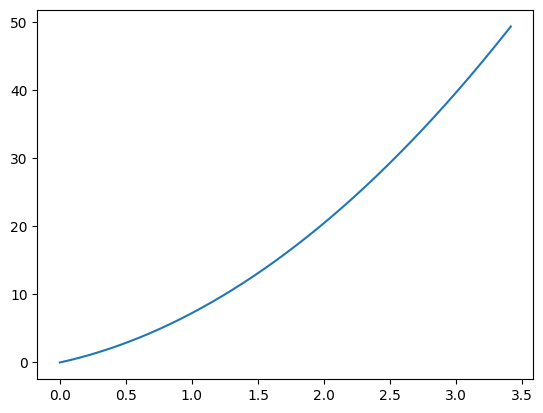

In [7]:
plt.plot( x_time, a*x_time**2+ b*x_time+0 )
#plt.plot( x_time, a*x_time**2+ b*x_time+-16 )

In [8]:
desired_y[0:5],desired_y[-5:]

(array([0.00705921, 0.01411843, 0.02117764, 0.02823686, 0.03529607]),
 array([49.38626314, 49.39332236, 49.40038157, 49.40744079, 49.4145    ]))

In [9]:
# The measured movement follows this quadratic behavior. (Empirical, fit to a quadratic)
# So, invert to find the time between steps (the xs) that yield equally spaced desired_y's
a=2.983135 #3.8687
b=4.28199 #4.8654
c=0.4721
desired_times=(-b+np.sqrt(b**2-4*a*(-desired_y)))/(2*a)
intervals=np.diff(desired_times)

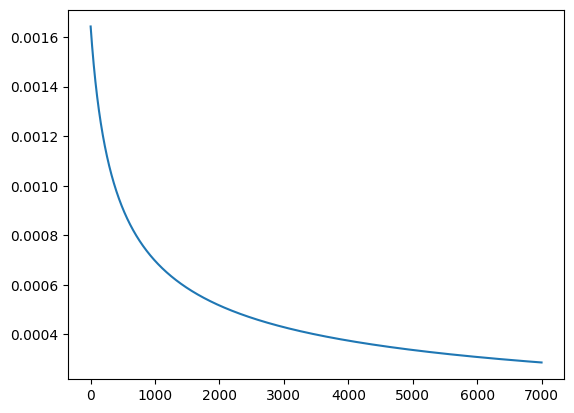

In [10]:
# Time between steps. This gets shorter as time goes on, since the motor needs
# to "speed up" to compensave for the nonlinear behavior of the vertical movement
# of the scissors lift (compared to the linear horizontal motion).
plt.plot(x[1:],intervals)

In [11]:
intervals[0:],intervals[-5:] # These match Chloe's spreadsheet

(array([0.00164293, 0.0016392 , 0.00163549, ..., 0.00028634, 0.00028632,
        0.0002863 ]),
 array([0.00028638, 0.00028636, 0.00028634, 0.00028632, 0.0002863 ]))

In [12]:
intervals_usec = intervals * 1000000 # Convert to usec

In [13]:
#intervals_usec = intervals_usec * 0 + 250 # To test a constants inverval

In [14]:
# Scale the intervals to uint8 for the table, going from 0-254 (linear)
# We lose precision, of course, but hopefully with rounding are
# still close to the desired behavior.

INTERVAL_TABLE_MAX=254.0 # uint8, from 0-254

expander_exponent=11 # To get a more accurate int, multiply/divide by this (2k)

interval_min=np.round( np.min(intervals_usec) )
interval_max=np.max(intervals_usec)
scaler=((interval_max-interval_min)/INTERVAL_TABLE_MAX)
scaler_expanded=np.round( scaler*(2**expander_exponent) )
if scaler==0: scaler=1 # For constants scalar might be 0

intervals_int8=np.round( (intervals_usec-interval_min)/scaler )
intervals_int8_recon = np.array(
    intervals_int8 * scaler_expanded/(2**expander_exponent) + interval_min, dtype=int)

In [15]:
interval_min,interval_max,scaler,scaler_expanded,intervals_int8

(286.0,
 1642.9325944709465,
 5.342254308940734,
 10941.0,
 array([254., 253., 253., ...,   0.,   0.,   0.]))

In [16]:
np.sum(intervals_int8_recon[250:-250]) # Should be close to 3sec

3004330

In [17]:
intervals_int8[0:5],intervals_int8[-5:]

(array([254., 253., 253., 252., 251.]), array([0., 0., 0., 0., 0.]))

In [18]:
fil=open('lookup_table1.h','wt')
fil.writelines('const unsigned int table1_info[] = {\n')
fil.writelines('\t%d, //num_steps\n'%num_steps);
fil.writelines('\t%d, //const unsigned int table_scaler = ;\n'%scaler_expanded);
fil.writelines('\t%d, //const unsigned int table_expander_exponent = ;\n'%expander_exponent);
fil.writelines('\t%d}; //const unsigned int table_interval_min = };\n'%interval_min);
fil.writelines('const PROGMEM uint8_t table1[] = {\n');
for nelement in intervals_int8:
    fil.writelines('%d,\n'%nelement)
fil.writelines('};\n');
fil.close()

In [19]:
if np.max(intervals_int8)>2**8:
    print("Problem, exceeded 8-bit table.")
else:
    print("Ok. Please close/reopen Arduino IDE and recompile")
    print( datetime.datetime.now() )

Ok. Please close/reopen Arduino IDE and recompile
2023-07-11 12:53:57.547880
